In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import os
import sys
sys.path.append(os.path.abspath(".."))
pd.set_option("display.precision", 2)
from ficaria.missing_imputation import FCMCentroidImputer, FCMParameterImputer, FCMRoughParameterImputer
from ficaria.feature_selection import WeightedFuzzyRoughSelector

### FS

In [2]:
np.random.seed(42)

n = 100

living_area = np.random.randint(40, 121, n)
num_rooms = np.clip((living_area / 20 + np.random.normal(0, 0.8, n)).round(), 1, 6).astype(int)
districts = np.random.choice(["A", "B", "C", "D"], size=n, p=[0.25, 0.25, 0.25, 0.25])
distance_to_park = np.random.randint(200, 2000, n)
roof_type = np.random.choice(["Flat", "Gable", "Hip"], size=n)

district_effect = {"A": 0, "B": 5, "C": 10, "D": 15}

price = (
    2.5 * living_area
    + 10 * num_rooms
    + [district_effect[d] for d in districts]
    + np.random.normal(0, 15, n)
)

price = (price / 10).round(1)

id_col = np.arange(1, n + 1)
tech = np.ones(n, dtype=int)

data = pd.DataFrame({
    "id": id_col,
    "living_area": living_area,
    "num_rooms": num_rooms,
    "district": districts,
    "distance_to_park": distance_to_park,
    "roof_type": roof_type,
    "price": price,
    "tech": tech
})

In [3]:
X = data.drop(columns=['price'])
y = data['price']

selector = WeightedFuzzyRoughSelector(n_features=2, alpha=0.5, k=10)
feature_importance = selector.fit(X, y)

In [4]:
selector.feature_importances_

,feature,importance
0,living_area,0.35
1,distance_to_park,0.29
2,id,0.28
3,num_rooms,0.20
4,district,0.18
5,roof_type,0.18
6,tech,0.17


#### Eksperyment

In [9]:
def feature_selection_experiment(X_train, y_train,X_test, y_test, title, alpha, k):
    accuracies =[]
    n_features_total = X_train.shape[1]

    selector = WeightedFuzzyRoughSelector(n_features=1, alpha=alpha, k=k)
    selector.fit(X_train, y_train)
    
    for n in range(1, n_features_total + 1):
        selected_idx = selector.feature_sequence_[:n]
        
        X_train_sel = X_train.iloc[:, selected_idx]
        X_test_sel  = X_test.iloc[:, selected_idx]
        
        clf = KNeighborsClassifier(n_neighbors=3)
        clf.fit(X_train_sel, y_train)
        
        y_pred = clf.predict(X_test_sel)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"n = {n} features → accuracy = {acc:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(range(1, n_features_total+1), accuracies, marker='o')
    plt.title(title)
    plt.xlabel("The number of features")
    plt.ylabel("Classification accuracy")
    plt.show()

    return accuracies

n = 1 features → accuracy = 0.6296
n = 2 features → accuracy = 0.9444
n = 3 features → accuracy = 0.9630
n = 4 features → accuracy = 0.9444
n = 5 features → accuracy = 0.9630
n = 6 features → accuracy = 0.9630
n = 7 features → accuracy = 0.9630
n = 8 features → accuracy = 0.9630
n = 9 features → accuracy = 0.9444
n = 10 features → accuracy = 0.9444
n = 11 features → accuracy = 0.9444
n = 12 features → accuracy = 0.9444
n = 13 features → accuracy = 0.9444


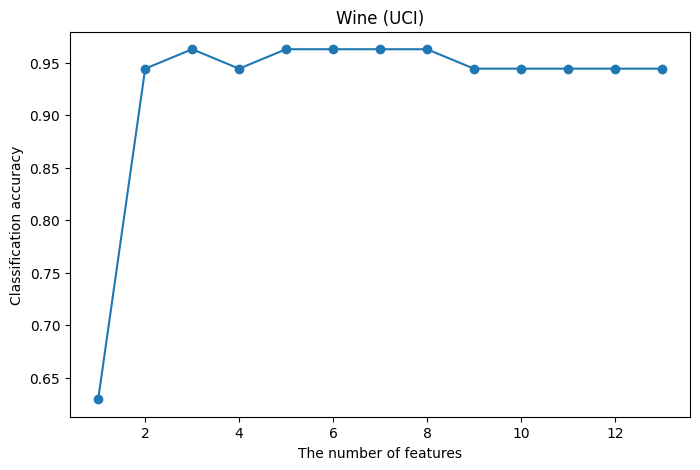

In [6]:
# alpha = 0.5 k = 10
data = load_wine(as_frame=True)
X_full = data.data
y = data.target
feature_names = X_full.columns.tolist()

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_full = pd.DataFrame(X_full_scaled, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, stratify=y, random_state=42
)

acc = feature_selection_experiment(X_train, y_train,X_test, y_test, "Wine (UCI)", 0.5, 10)

Sonar Dataset Feature Selection Experiment:
n = 1 features → accuracy = 0.5556
n = 2 features → accuracy = 0.5397
n = 3 features → accuracy = 0.7619
n = 4 features → accuracy = 0.7937
n = 5 features → accuracy = 0.7619
n = 6 features → accuracy = 0.7937
n = 7 features → accuracy = 0.7619
n = 8 features → accuracy = 0.7778
n = 9 features → accuracy = 0.7937
n = 10 features → accuracy = 0.7778
n = 11 features → accuracy = 0.7778
n = 12 features → accuracy = 0.8095
n = 13 features → accuracy = 0.8254
n = 14 features → accuracy = 0.8254
n = 15 features → accuracy = 0.8254
n = 16 features → accuracy = 0.8254
n = 17 features → accuracy = 0.8095
n = 18 features → accuracy = 0.7937
n = 19 features → accuracy = 0.8254
n = 20 features → accuracy = 0.7937
n = 21 features → accuracy = 0.8095
n = 22 features → accuracy = 0.7937
n = 23 features → accuracy = 0.8095
n = 24 features → accuracy = 0.7778
n = 25 features → accuracy = 0.7778
n = 26 features → accuracy = 0.7937
n = 27 features → accuracy = 

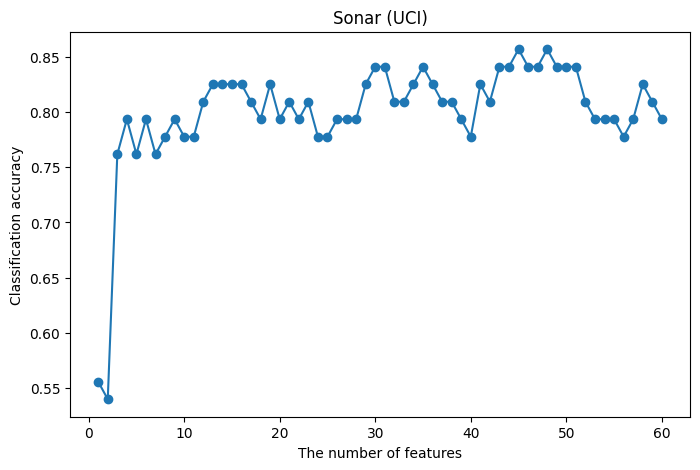

In [10]:
import requests
from io import StringIO

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text), header=None)

X_full = data.iloc[:, :-1]
y = data.iloc[:, -1].map({'R':0, 'M':1})  # zamiana na 0/1
feature_names = X_full.columns.tolist()

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_full = pd.DataFrame(X_full_scaled, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, stratify=y, random_state=42
)

print("Sonar Dataset Feature Selection Experiment:")

acc = feature_selection_experiment(X_train, y_train, X_test, y_test, "Sonar (UCI)", 0.3, 20)

### MI

In [ ]:
# Sample data
data = pd.DataFrame({
    'age': [25, 26, 28, 51, 53, 72, 75, np.nan],
    'income': [50000, 55000, 58000, 85000, 90000, 120000, 125000, 100000]
})

imputer = FCMCentroidImputer(n_clusters=3)
imputer.fit(data)
filled_data = imputer.transform(data)

print(filled_data)

    age  income
0  25.0   50000
1  26.0   55000
2  28.0   58000
3  51.0   85000
4  53.0   90000
5  72.0  120000
6  75.0  125000
7  52.0  100000


In [3]:
data = pd.DataFrame({
    'systolic_bp': [120, 130, 125, np.nan, 140, 135, np.nan, 150],
    'diastolic_bp': [80, 85, np.nan, 88, 90, 82, 95, 100],
    'heart_rate': [70, 72, 75, np.nan, 78, 80, 76, np.nan]
})

imputer = FCMParameterImputer(n_clusters=3)
imputer.fit(data)
filled_data = imputer.transform(data)

print(filled_data)

   systolic_bp  diastolic_bp  heart_rate
0       120.00         80.00       70.00
1       130.00         85.00       72.00
2       125.00         82.15       75.00
3       138.15         88.00       77.45
4       140.00         90.00       78.00
5       135.00         82.00       80.00
6       136.95         95.00       76.00
7       150.00        100.00       76.95


In [4]:
data = pd.DataFrame({
    'temperature': [21.5, 22.0, np.nan, 23.1, 21.8, 22.3, np.nan, 22.7],
    'humidity': [40, 42, 38, np.nan, 41, 43, 39, np.nan],
    'pressure': [1012, 1013, 1011, 1010, np.nan, 1014, 1012, np.nan]
})

imputer = FCMRoughParameterImputer(n_clusters=3, max_iter=1000)
imputer.fit(data)
filled_data = imputer.transform(data)
print(filled_data)

   temperature  humidity  pressure
0         21.5      40.0    1012.0
1         22.0      42.0    1013.0
2         21.5      38.0    1011.0
3         23.1      40.0    1010.0
4         21.8      41.0    1013.0
5         22.3      43.0    1014.0
6         21.5      39.0    1012.0
7         22.7      43.0    1014.0
